In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


# import os
# import sys
# %cd /content/drive/MyDrive/CC/1115

Mounted at /content/drive
/content/drive/MyDrive/CC/1115


# CC's LSTM for stock prediction

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
dataset_df1 = pd.read_csv("./data/complete_data.csv")

# dataset_df = dataset1.drop(columns={'Dividends','Stock Splits'})
# dataset_df

dataset_df = dataset_df1.drop(columns={'Dividends','Stock Splits','Unnamed: 0','Date'})
dataset_df = dataset_df.drop(columns={'AMZ_Volume','Apple_Volume','SP_Volume','GOOG_Volume','MS_Volume','ORC_Volume'})

In [4]:
dataset_df

,AMZ_Open,AMZ_High,AMZ_Low,AMZ_Close,Apple_Open,Apple_High,Apple_Low,Apple_Close,GOOG_Open,GOOG_High,...,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,8.794500,8.974000,8.777500,8.951500,12.540048,12.578776,12.472047,12.540048,16.262545,16.641375,...,8.954000,9.238143,8.951500,8.951500,0.000000,0.339056,9.914319,8.561966,8.951500,7.951500
1,8.960500,9.025000,8.803500,8.875500,12.607435,12.645249,12.480581,12.607435,16.563665,16.693678,...,8.954000,9.238143,8.912038,8.910333,-0.001705,0.339056,9.914319,8.561966,8.894500,7.875500
2,8.797000,8.912500,8.702500,8.880500,12.747405,12.763261,12.583957,12.747405,16.491436,16.537264,...,8.954000,9.238143,8.900707,8.898689,-0.002018,0.339056,9.914319,8.561966,8.884808,7.880500
3,8.903500,9.232500,8.875000,9.130500,12.880662,12.891335,12.783691,12.880662,16.417213,16.438385,...,8.954000,9.238143,8.964947,8.971863,0.006916,0.339056,9.914319,8.561966,9.050650,8.130500
4,9.138000,9.218500,8.850000,8.928000,12.860233,13.043807,12.848645,12.860233,16.102144,16.114599,...,8.954000,9.238143,8.956379,8.959946,0.003567,0.339056,9.914319,8.561966,8.968546,7.928000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,171.037003,172.942993,169.215500,169.669495,179.586868,179.676494,176.340308,179.586868,147.463501,148.426498,...,169.737071,172.019573,172.005465,170.872064,-1.133401,2.881120,177.781813,166.257334,170.080147,168.669495
2513,170.182495,172.175995,169.135498,170.660995,178.551132,180.582734,177.794270,178.551132,148.374496,148.374496,...,169.992785,171.802097,171.905875,170.839592,-1.066283,2.489139,176.780374,166.823820,170.467379,169.660995
2514,170.839996,171.212006,168.600494,169.201004,178.640778,179.885626,177.405882,178.640778,146.429504,147.183746,...,169.876142,171.379359,171.705514,170.587501,-1.118013,2.363310,176.105978,166.652740,169.623129,168.201004
2515,169.699997,170.888000,168.524002,168.644501,177.465637,179.825881,177.356090,177.465637,146.449997,147.062500,...,170.099786,171.059883,171.478772,170.288578,-1.190194,2.416104,175.892091,166.227674,168.970710,167.644501


## Hyper parameters

In [5]:
# for dataset splitting
TRAIN_RATIO = 8
VALIDATION_RATIO = 1
TEST_RATIO = 1

# Using previous 60 days data to predict next days close price
## time window size
TIME_WINDOW_SIZE = 90
## feature size
NFEATURES = 43
## forescast size
FORECAST_SIZE = 1

# Model related parameters
BATCH_SIZE = 4 # for LSTM, don't use large batch_size
EPOCH = 100

# Train related parameters
MODEL_SAVED_PATH = "./saved_model/exp_new4/"
init_epoch = 0

## Load dataset from csv and split train, validation and test dataset (8:1:1)

In [3]:
# dataset_df1 = pd.read_csv("./data/new_dataset.csv")

# # dataset_df = dataset1.drop(columns={'Dividends','Stock Splits'})
# # dataset_df

# dataset_df = dataset_df1.drop(columns={'Dividends','Stock Splits','Unnamed: 0','Date'})
# dataset_df = dataset_df.drop(columns={'AMZ_Volume','Apple_Volume','SP_Volume','GOOG_Volume','MS_Volume','ORC_Volume'})

In [6]:
dataset_df

,AMZ_Open,AMZ_High,AMZ_Low,AMZ_Close,Apple_Open,Apple_High,Apple_Low,Apple_Close,GOOG_Open,GOOG_High,...,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,8.794500,8.974000,8.777500,8.951500,12.540048,12.578776,12.472047,12.540048,16.262545,16.641375,...,8.954000,9.238143,8.951500,8.951500,0.000000,0.339056,9.914319,8.561966,8.951500,7.951500
1,8.960500,9.025000,8.803500,8.875500,12.607435,12.645249,12.480581,12.607435,16.563665,16.693678,...,8.954000,9.238143,8.912038,8.910333,-0.001705,0.339056,9.914319,8.561966,8.894500,7.875500
2,8.797000,8.912500,8.702500,8.880500,12.747405,12.763261,12.583957,12.747405,16.491436,16.537264,...,8.954000,9.238143,8.900707,8.898689,-0.002018,0.339056,9.914319,8.561966,8.884808,7.880500
3,8.903500,9.232500,8.875000,9.130500,12.880662,12.891335,12.783691,12.880662,16.417213,16.438385,...,8.954000,9.238143,8.964947,8.971863,0.006916,0.339056,9.914319,8.561966,9.050650,8.130500
4,9.138000,9.218500,8.850000,8.928000,12.860233,13.043807,12.848645,12.860233,16.102144,16.114599,...,8.954000,9.238143,8.956379,8.959946,0.003567,0.339056,9.914319,8.561966,8.968546,7.928000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,171.037003,172.942993,169.215500,169.669495,179.586868,179.676494,176.340308,179.586868,147.463501,148.426498,...,169.737071,172.019573,172.005465,170.872064,-1.133401,2.881120,177.781813,166.257334,170.080147,168.669495
2513,170.182495,172.175995,169.135498,170.660995,178.551132,180.582734,177.794270,178.551132,148.374496,148.374496,...,169.992785,171.802097,171.905875,170.839592,-1.066283,2.489139,176.780374,166.823820,170.467379,169.660995
2514,170.839996,171.212006,168.600494,169.201004,178.640778,179.885626,177.405882,178.640778,146.429504,147.183746,...,169.876142,171.379359,171.705514,170.587501,-1.118013,2.363310,176.105978,166.652740,169.623129,168.201004
2515,169.699997,170.888000,168.524002,168.644501,177.465637,179.825881,177.356090,177.465637,146.449997,147.062500,...,170.099786,171.059883,171.478772,170.288578,-1.190194,2.416104,175.892091,166.227674,168.970710,167.644501


In [7]:
# transfer pandas dataframe to numpy ndarray
dataset_np = np.array(dataset_df.iloc[:, 0:])
dataset_np.shape

(2517, 43)

In [8]:
# dataset_df = dataset_df.drop(columns=['Unnamed: 0', 'Date'])
# dataset_df

In [9]:
# split train, validation and test
dataset_size = dataset_np.shape[0]
dataset_segment = dataset_size // 10
train_dataset = dataset_np[:TRAIN_RATIO * dataset_segment]
validation_dataset = dataset_np[TRAIN_RATIO * dataset_segment: (TRAIN_RATIO + VALIDATION_RATIO) * dataset_segment]
test_dataset = dataset_np[(TRAIN_RATIO + VALIDATION_RATIO) * dataset_segment:]

train_dataset.shape, validation_dataset.shape, test_dataset.shape

((2008, 43), (251, 43), (258, 43))

### save dataset to file

In [10]:
dataset_pickle_folder = "./data/pickles"
train_set_filename = "train_set.pk"
valid_set_filename = "valid_set.pk"
test_set_filename = "test_set.pk"

train_set_path = os.path.join(dataset_pickle_folder, train_set_filename)
valid_set_path = os.path.join(dataset_pickle_folder, valid_set_filename)
test_set_path = os.path.join(dataset_pickle_folder, test_set_filename)

with open(train_set_path, "wb") as fp:
    pickle.dump(train_dataset, fp)

with open(valid_set_path, "wb") as fp:
    pickle.dump(validation_dataset, fp)

with open(test_set_path, "wb") as fp:
    pickle.dump(test_dataset, fp)

print("Done")

Done


### load dataset from file (starts here)

In [11]:
dataset_pickle_folder = "./data/pickles"
train_set_filename = "train_set.pk"
valid_set_filename = "valid_set.pk"
test_set_filename = "test_set.pk"

train_set_path = os.path.join(dataset_pickle_folder, train_set_filename)
valid_set_path = os.path.join(dataset_pickle_folder, valid_set_filename)
test_set_path = os.path.join(dataset_pickle_folder, test_set_filename)

with open(train_set_path, "rb") as fp:
    train_dataset = pickle.load(fp)

with open(valid_set_path, "rb") as fp:
    validation_dataset = pickle.load(fp)

with open(test_set_path, "rb") as fp:
    test_dataset = pickle.load(fp)

train_dataset.shape, validation_dataset.shape, test_dataset.shape

((2008, 43), (251, 43), (258, 43))

## Define data normalization function

In [12]:
def normalize_by_column_within_time_window(x, y):
  # x.shape = (window_size, 40)
  # y.shape = (forecast_size)
    EPS = 1e-5
    ret_x = np.array(x)
    ret_y = np.array(y)

    train_close_price_min = np.min(ret_x[:, 3]) # the 3rd column of x is the AMZN close price
    train_close_price_max = np.max(ret_x[:, 3])

    for i in range(ret_x.shape[1]):
        column_min = np.min(ret_x[:, i])
        column_max = np.max(ret_x[:, i])
#     print("debug:", i, column_min, column_max)
        ret_x[:, i] = (ret_x[:, i] - column_min) / (column_max - column_min + EPS)  # EPS for value stability (x / 0.000000000000000001 will be huge)

  
    ret_y = (ret_y - train_close_price_min) / (train_close_price_max - train_close_price_min + EPS)
  
    return ret_x, ret_y

In [ ]:
# # fix every column into [0, 1)
# train_data_norm = normalize_by_column(train_dataset)
# validation_dataset_norm = normalize_by_column(validation_dataset)
# test_dataset_norm = normalize_by_column(test_dataset)

In [ ]:
# np.min(train_data_norm[:, 0]), np.max(train_data_norm[:, 0])

## Define Kears data generator (keras.utils.Sequence)

In [13]:
class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, dataset, batch_size, window_size, forecast_size, shuffle=False, normalization=True):
    self.dataset = dataset  # shape = (n, features)
    self.batch_size = batch_size
    self.window_size = window_size
    self.forecast_size = forecast_size

    self.x = []             # final x.shape = (-1, window_size, features)
    self.y = []             # final y.shape = (-1, forecast_size)
    for i in range(self.dataset.shape[0] - window_size - forecast_size):
      # cur_x: dataset[i: i + window_size], shape = (window_size, nfeatures)
      # cur_y: dataset[i + window_size: i + window_size + forecast_size, 3], shape = shape = (window_size, 1)
      # normalize_by_column_within_time_window fix x and y to around [0, 1]
      if normalization: 
        cur_x, cur_y = normalize_by_column_within_time_window(dataset[i: i + window_size, :], dataset[i + window_size: i + window_size + forecast_size, 3].reshape(-1, forecast_size))
      else:
        cur_x = dataset[i: i + window_size, :]
        cur_y = dataset[i + window_size: i + window_size + forecast_size, 3].reshape(-1, forecast_size)

      self.x.append(cur_x)
      self.y.append(cur_y)
      
    self.x = np.array(self.x)
    self.y = np.array(self.y).reshape(-1, forecast_size)
    
    if shuffle:
      shuffle_idx = np.random.permutation(self.x.shape[0])
      self.x = self.x[shuffle_idx, :, :]
      self.y = self.y[shuffle_idx, :]

  def __len__(self):
    return self.x.shape[0] // self.batch_size

  def __getitem__(self, idx):
    # return one batch data 
    # x: (batch_size, window_size, features)
    # y: (batch_size, forecast_size, 1)
    batch_x = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]

    return batch_x, batch_y

In [14]:
train_gen = DataGenerator(dataset=train_dataset, batch_size=BATCH_SIZE, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=True)
valid_gen = DataGenerator(dataset=validation_dataset, batch_size=BATCH_SIZE, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=False)

# test generator does not need normalization... since it's not used in training
# but it only used in the inference process
# to easily draw the figures, just set batch_size as 1 and normalization as false
test_gen = DataGenerator(dataset=test_dataset, batch_size=1, window_size=TIME_WINDOW_SIZE, forecast_size=FORECAST_SIZE, shuffle=False, normalization=False)

In [15]:
train_batch_x, train_batch_y = train_gen[0]
train_batch_x.shape, train_batch_y.shape
# should be (batch, window_size, nfeatures) and (batch, forecast_size)

((4, 90, 43), (4, 1))

In [16]:
train_batch_y[0]

array([0.98608263])

## Define sequential model and train related stuff

In [17]:
class LSTMPredictor(keras.Model):

  def __init__(self, input_shape, forecast_size): 
    # input shape should be (batch, window_size, features)
    super().__init__()

    self.lstm1 = keras.layers.LSTM(50, activation="sigmoid", input_shape=input_shape, return_sequences=True)  # (batch, window_size, 10)
    self.dropout1 = keras.layers.Dropout(0.1)

    self.lstm2 = keras.layers.LSTM(100, activation="sigmoid", return_sequences=False) # (batch, window_size, 32)
    self.dropout2 = keras.layers.Dropout(0.1)

    self.dense5 = keras.layers.Dense(forecast_size) # (batch, forecast_size)
  
  def call(self, inputs):
    x = self.lstm1(inputs)
    x = self.dropout1(x)
    x = self.lstm2(x)
    x = self.dropout2(x)

    x = self.dense5(x)
    return x

In [18]:
model = LSTMPredictor(input_shape=(-1, TIME_WINDOW_SIZE, NFEATURES), forecast_size=FORECAST_SIZE)

# optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
# sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

model.compile(optimizer=adam, loss="mse", metrics=["mape"])
model.build(input_shape=(BATCH_SIZE, TIME_WINDOW_SIZE, NFEATURES))
model.summary()

2022-11-22 01:21:26.867273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 01:21:26.867314: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 01:21:26.867339: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-24-249): /proc/driver/nvidia/version does not exist
2022-11-22 01:21:26.867573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning:

Model: "lstm_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  18800     
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 lstm_1 (LSTM)               multiple                  60400     
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense (Dense)               multiple                  101       
                                                                 
Total params: 79,301
Trainable params: 79,301
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [20]:
# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath=MODEL_SAVED_PATH + 'LSTM_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename=MODEL_SAVED_PATH + 'LSTM_training_log.csv',
                       separator=',',
                       append=True)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             reduce_lr,
             terminate_on_nan]

## Train

In [21]:
history = model.fit(train_gen, 
                    epochs=EPOCH,
                    validation_data=valid_gen,
                    callbacks=callbacks,
                    initial_epoch=init_epoch);

Epoch 1/100
479/479 [==============================] - ETA: 0s - loss: 0.0778 - mape: 106.3169
Epoch 1: val_loss improved from inf to 0.01312, saving model to ./saved_model/exp_new4/LSTM_epoch-01_loss-0.0778_val_loss-0.0131.h5
479/479 [==============================] - 39s 76ms/step - loss: 0.0778 - mape: 106.3169 - val_loss: 0.0131 - val_mape: 17.2909 - lr: 0.0010
Epoch 2/100
479/479 [==============================] - ETA: 0s - loss: 0.0282 - mape: 53.7795
Epoch 2: val_loss improved from 0.01312 to 0.01013, saving model to ./saved_model/exp_new4/LSTM_epoch-02_loss-0.0282_val_loss-0.0101.h5
479/479 [==============================] - 36s 74ms/step - loss: 0.0282 - mape: 53.7795 - val_loss: 0.0101 - val_mape: 15.6846 - lr: 0.0010
Epoch 3/100
479/479 [==============================] - ETA: 0s - loss: 0.0208 - mape: 46.0030
Epoch 3: val_loss did not improve from 0.01013
479/479 [==============================] - 34s 72ms/step - loss: 0.0208 - mape: 46.0030 - val_loss: 0.0110 - val_mape: 17

Epoch 27/100
479/479 [==============================] - ETA: 0s - loss: 0.0088 - mape: 31.6617
Epoch 27: val_loss did not improve from 0.00502
479/479 [==============================] - 36s 75ms/step - loss: 0.0088 - mape: 31.6617 - val_loss: 0.0051 - val_mape: 10.1343 - lr: 1.0000e-05
Epoch 28/100
479/479 [==============================] - ETA: 0s - loss: 0.0090 - mape: 34.9355
Epoch 28: val_loss did not improve from 0.00502
479/479 [==============================] - 42s 88ms/step - loss: 0.0090 - mape: 34.9355 - val_loss: 0.0051 - val_mape: 10.0283 - lr: 1.0000e-05
Epoch 29/100
479/479 [==============================] - ETA: 0s - loss: 0.0087 - mape: 33.9651
Epoch 29: val_loss did not improve from 0.00502
479/479 [==============================] - 37s 76ms/step - loss: 0.0087 - mape: 33.9651 - val_loss: 0.0051 - val_mape: 10.1012 - lr: 1.0000e-05
Epoch 30/100
479/479 [==============================] - ETA: 0s - loss: 0.0088 - mape: 37.2445
Epoch 30: val_loss did not improve from 0.00

Epoch 56/100
479/479 [==============================] - ETA: 0s - loss: 0.0089 - mape: 29.8797
Epoch 56: val_loss did not improve from 0.00502
479/479 [==============================] - 40s 83ms/step - loss: 0.0089 - mape: 29.8797 - val_loss: 0.0051 - val_mape: 9.8981 - lr: 1.0000e-05
Epoch 57/100
479/479 [==============================] - ETA: 0s - loss: 0.0088 - mape: 34.3117
Epoch 57: val_loss did not improve from 0.00502
479/479 [==============================] - 39s 81ms/step - loss: 0.0088 - mape: 34.3117 - val_loss: 0.0051 - val_mape: 10.0025 - lr: 1.0000e-05
Epoch 58/100
479/479 [==============================] - ETA: 0s - loss: 0.0088 - mape: 35.6786
Epoch 58: val_loss did not improve from 0.00502
479/479 [==============================] - 37s 78ms/step - loss: 0.0088 - mape: 35.6786 - val_loss: 0.0051 - val_mape: 10.1533 - lr: 1.0000e-05
Epoch 59/100
479/479 [==============================] - ETA: 0s - loss: 0.0090 - mape: 36.4755
Epoch 59: val_loss did not improve from 0.005

Epoch 85/100
479/479 [==============================] - ETA: 0s - loss: 0.0089 - mape: 32.0694
Epoch 85: val_loss did not improve from 0.00502
479/479 [==============================] - 36s 75ms/step - loss: 0.0089 - mape: 32.0694 - val_loss: 0.0051 - val_mape: 10.0816 - lr: 1.0000e-05
Epoch 86/100
479/479 [==============================] - ETA: 0s - loss: 0.0086 - mape: 35.2956
Epoch 86: val_loss did not improve from 0.00502
479/479 [==============================] - 36s 75ms/step - loss: 0.0086 - mape: 35.2956 - val_loss: 0.0051 - val_mape: 9.9993 - lr: 1.0000e-05
Epoch 87/100
479/479 [==============================] - ETA: 0s - loss: 0.0090 - mape: 36.6090
Epoch 87: val_loss did not improve from 0.00502
479/479 [==============================] - 33s 70ms/step - loss: 0.0090 - mape: 36.6090 - val_loss: 0.0051 - val_mape: 10.0450 - lr: 1.0000e-05
Epoch 88/100
479/479 [==============================] - ETA: 0s - loss: 0.0087 - mape: 29.2079
Epoch 88: val_loss did not improve from 0.005

## Inference

In [22]:
# load model
model_name = "LSTM_epoch-23_loss-0.0092_val_loss-0.0050.h5"
weight_path = os.path.join(MODEL_SAVED_PATH, model_name)
pred_model = LSTMPredictor(input_shape=(-1, TIME_WINDOW_SIZE, NFEATURES), forecast_size=FORECAST_SIZE)
pred_model.build(input_shape=(BATCH_SIZE, TIME_WINDOW_SIZE, NFEATURES))

pred_model.load_weights(weight_path)

In [23]:
def inference(model, test_data, verbose=False):
  # test_data should be (window_size, 40)
    test_data_tmp = np.copy(test_data)
    EPS = 1e-5
    close_price_min = np.min(test_data_tmp[:, 3]) # the 3rd column of x is the close price
    close_price_max = np.max(test_data_tmp[:, 3]) # the 3rd column of x is the close price
    for i in range(test_data.shape[1]):
        column_min = np.min(test_data_tmp[:, i])
        column_max = np.max(test_data_tmp[:, i])
        test_data_tmp[:, i] = (test_data_tmp[:, i] - column_min) / (column_max - column_min + EPS)

    y_pred = model.predict(test_data_tmp.reshape(1, test_data_tmp.shape[0], test_data_tmp.shape[1]), verbose = verbose)
    y_pred = y_pred * (close_price_max - close_price_min + EPS) + close_price_min
    return y_pred.reshape(-1)

In [24]:
def draw_inference(model, test_data, test_label):
  # test_data, test_label = test_gen[idx]
    y_history = test_data[:, 3] # the 3rd cloumn is the close price
    y_pred = inference(model, test_data)

    x_idxs = np.arange(test_data.shape[0] + test_label.shape[0], dtype=np.int32)

    plt.scatter(x_idxs[:test_data.shape[0]], y_history, marker="*")
    plt.plot(x_idxs[:test_data.shape[0]], y_history)

    plt.scatter(x_idxs[test_data.shape[0]: ], test_label, marker="D")
    plt.plot(x_idxs[test_data.shape[0]: ], test_label)

    plt.scatter(x_idxs[test_data.shape[0]: ], y_pred, marker="+")
    plt.plot(x_idxs[test_data.shape[0]: ], y_pred)

In [38]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [39]:
def draw_test_dataset(model, test_ds, window_size=60, y_column=3):
    history_prices = test_ds[:, y_column]
    history_index = np.arange(test_ds.shape[0])
    pred_prices = list()
    true_prices = list()
    pred_index = np.arange(window_size, test_ds.shape[0] - 1)

    pred_cnt = 0
    apes = list()

    for i in range(0, test_ds.shape[0] - window_size - 1): 
        cur_x = test_ds[i: i + window_size]
        pred_y = inference(model, cur_x)
        label_y = test_ds[i+window_size + 1, y_column]

        apes.append(np.abs(label_y - pred_y) / label_y)
        pred_prices.append(pred_y)
        true_prices.append(label_y)
  
    apes = np.array(apes)
    mape = np.mean(apes)

    plt.title("Predicted Price & Actual Price", fontsize=20)
    plt.rcParams["figure.figsize"] = (40,20)
    pred_prices = np.array(pred_prices)
    true_prices = np.array(true_prices)
    plt.plot(history_index, history_prices)
    plt.scatter(history_index, history_prices, marker="o")
    plt.plot(pred_index, pred_prices)
    plt.scatter(pred_index, pred_prices, marker="+")

    return pred_prices, true_prices
    

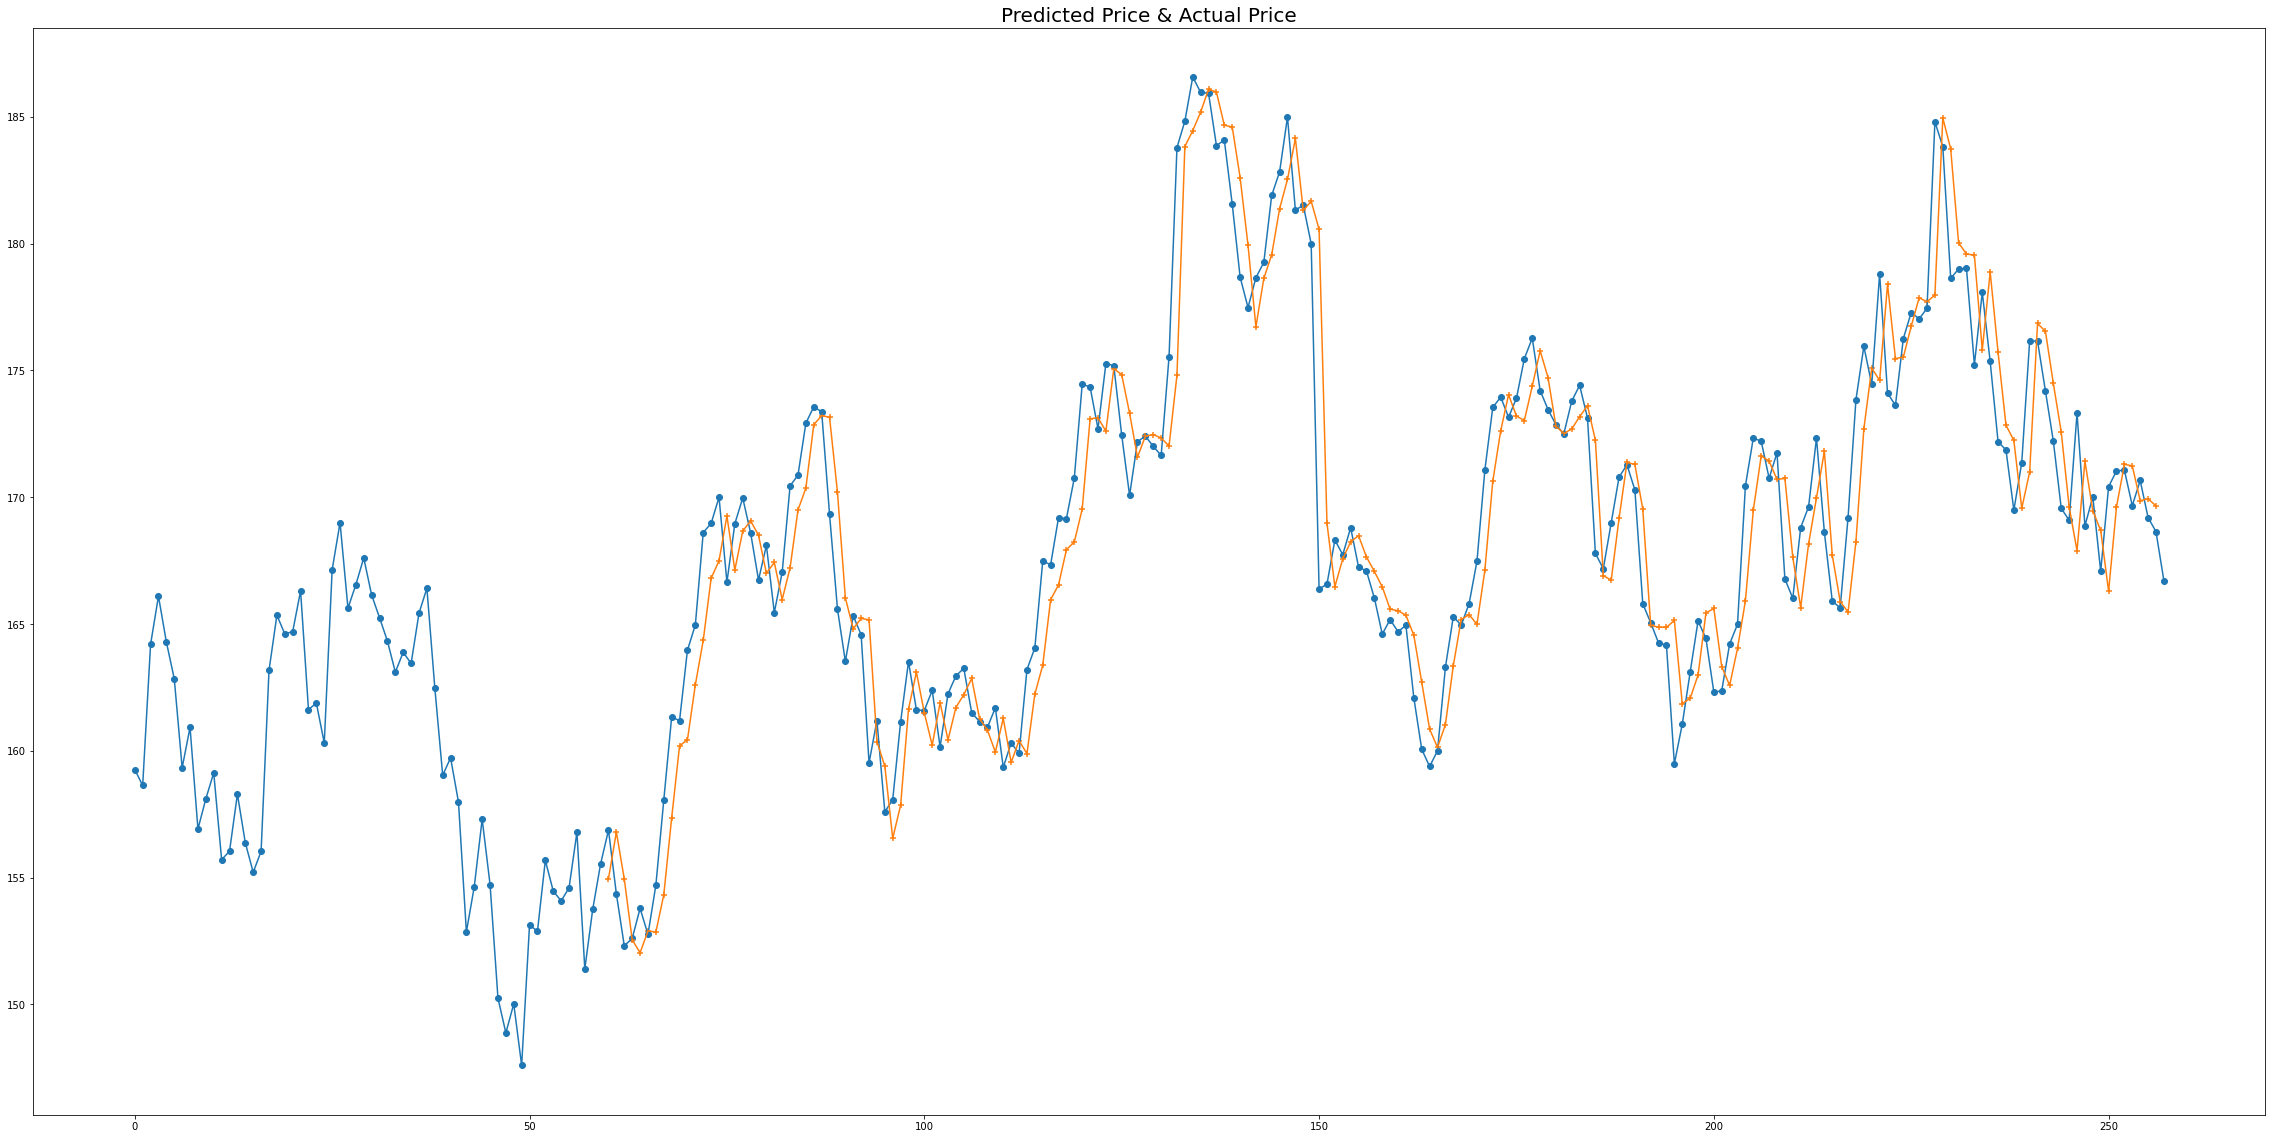

In [40]:
pred_prices, true_prices = draw_test_dataset(pred_model, test_dataset)

In [41]:
pred_prices.shape, true_prices.shape

((197, 1), (197,))

In [42]:
def performance_metrics(y_true, y_pred):    
    
    return r2_score(y_true,y_pred), mean_absolute_percentage_error(y_true, y_pred), mean_squared_error(y_true, y_pred,squared=False)
    
    

In [43]:
performance_metrics(true_prices, pred_prices)

(0.7122748904694242, 0.017139261802938538, 3.788040034232601)